# Spectrogram preprocessing in different Models & Scenarios

We tried this with a Spectrogram Callback first to extract Preprocessing and Raw Tensors directly from the Pipeline but it was impossible to match the raw Tensors between different models even though `shuffle=False`,`num_workers=1`, `batch_size=1`, and all `augmentations` were off...
So now we do it in an isolated Notebook which makes it easier but Pipeline Preprocessing might not be exactly the same

## Datamodules

### BEANS

In [1]:
from biofoundation.datamodule.beans_datamodule import BEANSDataModule
from birdset.datamodule.base_datamodule import DatasetConfig

def load_beans_dataset(n_classes, sample_rate, name):
    """
    Load the BEANS dataset.
    """
    datasetconfig = DatasetConfig(
        dataset_name=name,
        hf_path=f"DBD-research-group/{name}",
        hf_name="default",
        data_dir="../../../data_birdset",
        n_classes=n_classes,
        sample_rate=sample_rate
    )

    beans_datamodule = BEANSDataModule(dataset=datasetconfig)
    beans_dataset = beans_datamodule._load_data()
    beans_dataset = beans_datamodule._preprocess_data(beans_dataset)
    beans_dataset = beans_datamodule._create_splits(beans_dataset)
    return beans_dataset

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### BirdSet

In [2]:
from birdset.datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from datasets import Audio, load_from_disk
import os 

def load_birdset_dataset(sample_rate, name, split="test"):
    """
    Load the BirdSet dataset.
    """
    # Define the dataset configuration
    datasetconfig = DatasetConfig(
        hf_name=name,
        hf_path="DBD-research-group/BirdSet",
        data_dir=f"../../../data_birdset/{name}",
        sample_rate=sample_rate,
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
    )

    birdset_datamodule = BirdSetDataModule(dataset=datasetconfig)
    birdset_datamodule.prepare_data()
    dataset = load_from_disk(os.path.join(birdset_datamodule.disk_save_path, split))
    dataset = dataset.cast_column("filepath", Audio(sampling_rate=sample_rate))

    return dataset

## Load models and loop

In [3]:
import torch
import numpy as np

def convert(inputs, sample_rate=16000, length=10, birdset=False):
    """
    Convert the input to a tensor and 1 batch
    """
    # Get the audio array
    if birdset:
        audio = inputs["filepath"]["array"]
    else:
        audio = inputs["audio"]["array"]
    target_length = sample_rate * length
    # If audio is longer, cut from the end
    if len(audio) > target_length:
        audio = audio[-target_length:]
    # If audio is shorter, pad at the beginning
    elif len(audio) < target_length:
        pad = target_length - len(audio)
        audio = np.pad(audio, (pad, 0), mode="constant")
    return torch.tensor(audio, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

#### Convnext

In [4]:
from omegaconf import OmegaConf
from hydra.utils import instantiate
from birdset.datamodule.components.transforms import BirdSetTransformsWrapper

model_cfg = OmegaConf.create({
    "_target_": "biofoundation.modules.models.convnext.ConvNextModule",
    "num_classes": 0,
    "num_channels": 1,
    "checkpoint": "DBD-research-group/ConvNeXT-Base-BirdSet-XCL",
    "local_checkpoint": None,
    "classifier": None,
    "preprocess_in_model": False,
    "pooling": "default",
    "pretrain_info": {
        "hf_path": None,   # you can set these if needed
        "hf_name": None,
        "hf_pretrain_name": None,
        "valid_test_only": False
    }
})
convnext = instantiate(model_cfg)

def convnext_preprocessing(model, input_values,length):
    if model.__class__.__name__ == "ConvNextModule":
        # Apply BirdSetTransformsWrapper to input_values
        transforms = BirdSetTransformsWrapper(max_length=length)
        input_values = transforms._preprocess(input_values, torch.ones_like(input_values))

    return input_values

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DBD-research-group/ConvNeXT-Base-BirdSet-XCL were not used when initializing ConvNextForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ConvNextForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNextForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

BEATs

In [5]:
def beats_preprocessing(model, input_values, fbank_mean: float = 15.41663,fbank_std: float = 6.55582):
    if model.__class__.__name__ == "BEATsModel":
        input_values = model.model.preprocess(input_values,fbank_mean=fbank_mean, fbank_std=fbank_std)
    return input_values

In [6]:
from biofoundation.modules.models.audiomae import AudioMAEModel
from biofoundation.modules.models.vit_inatsound import Vit_iNatSoundModel
from biofoundation.modules.models.protoCLR import ProtoCLRModel
from tqdm import tqdm
from biofoundation.modules.models.beats import BEATsModel
# Add ProtoCLR
# ConvNext_bs, BEATs_NLM, Test PER 

models = [(convnext, 32_000, 5), (BEATsModel(num_classes=None), 16_000, 10)]  # (Model, Sample Rate)
beans_datasets = [("beans_dogs", 10)]  # (Dataset Name, Number of Classes)
birdset_datasets = ["PER"]
start_samples = 5 # From Dataset i to start
start_samples_beans = 13
num_samples = 1  # Number of samples to process from each dataset
spectrograms = {}
labels = {} 
for model, sample_rate, length in tqdm(models, desc="Models"):
    # Load beans datasets
    for beans_name, n_classes in beans_datasets:
        beans_dataset = load_beans_dataset(n_classes=n_classes, sample_rate=sample_rate, name=beans_name)
        for i in range(start_samples_beans, start_samples_beans + num_samples):
            input_tensor = convert(beans_dataset["test"][i], sample_rate=sample_rate, length=length)
            input_tensor = convnext_preprocessing(model, input_tensor,length=length)
            input_tensor = beats_preprocessing(model, input_tensor)
            #print( f"Processing {beans_name} sample {i} with shape {input_tensor.shape}")
            output = model._preprocess(input_values=input_tensor)
            var_name = f"{model.__class__.__name__}_{beans_name}_{i}"
            spectrograms[var_name] = output
    # Load birdset datasets
    for birdset_name in birdset_datasets:
        birdset_dataset = load_birdset_dataset(sample_rate=sample_rate, name=birdset_name)
        for i in range(start_samples, start_samples + num_samples):
            input_tensor = convert(birdset_dataset[i], sample_rate=sample_rate, length=length, birdset=True)
            input_tensor = convnext_preprocessing(model, input_tensor,length=length)
            input_tensor = beats_preprocessing(model, input_tensor)
            output = model._preprocess(input_values=input_tensor)
            var_name = f"{model.__class__.__name__}_{birdset_name}_{i}"
            spectrograms[var_name] = output
            labels[var_name]=birdset_dataset[i]["labels"]

spectrograms

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
sampling: 100%|██████████| 132/132 [00:03<00:00, 43.01it/s]


One-hot-encoding train labels. (num_proc=3):   0%|          | 0/65479 [00:00<?, ? examples/s]

Using the latest cached version of the module from /home/vscode/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Fri Jun 20 10:08:36 2025) since it couldn't be found locally at DBD-research-group/BirdSet, or remotely on the Hugging Face Hub.
/workspace/birdset/datamodule/base_datamodule.py:483: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
Using the latest cached version of the module from /home/vscode/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Fri Jun 20 10:08:36 2025) since it couldn't be found locally at DBD-research-group/B

Saving the dataset (0/1 shards):   0%|          | 0/52383 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13096 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

sampling: 100%|██████████| 132/132 [00:02<00:00, 44.13it/s]


One-hot-encoding train labels. (num_proc=3):   0%|          | 0/65479 [00:00<?, ? examples/s]

Using the latest cached version of the module from /home/vscode/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Fri Jun 20 10:08:36 2025) since it couldn't be found locally at DBD-research-group/BirdSet, or remotely on the Hugging Face Hub.
/workspace/birdset/datamodule/base_datamodule.py:483: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_one_hot_matrix = torch.tensor(class_one_hot_matrix, dtype=torch.float32)
Using the latest cached version of the module from /home/vscode/.cache/huggingface/modules/datasets_modules/datasets/DBD-research-group--BirdSet/c6d7d1c30e4d8f29c4fb5e358bc605ccb896681b869398c54db64721f45ac91e (last modified on Fri Jun 20 10:08:36 2025) since it couldn't be found locally at DBD-research-group/B

Saving the dataset (0/1 shards):   0%|          | 0/52383 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13096 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/15120 [00:00<?, ? examples/s]

Models: 100%|██████████| 2/2 [02:29<00:00, 74.97s/it]


{'ConvNextModule_beans_dogs_13': tensor([[[[ 6.7181,  6.4971,  6.7921,  ..., 16.5752, 16.5752, 16.5752],
           [ 5.5479,  5.3270,  5.6220,  ..., 16.5752, 16.5752, 16.5752],
           [ 7.5456,  7.6979,  8.5626,  ..., 16.5752, 16.5752, 16.5752],
           ...,
           [ 6.4172,  6.6465,  7.4371,  ..., 16.5752, 16.5752, 16.5752],
           [ 6.7134,  7.0980,  7.4104,  ..., 16.5752, 16.5752, 16.5752],
           [ 9.4787,  9.4787,  9.4787,  ..., 16.5752, 16.5752, 16.5752]]]]),
 'ConvNextModule_PER_5': tensor([[[[ 2.5187,  0.7452,  0.2044,  ..., 16.5752, 16.5752, 16.5752],
           [ 1.3486, -0.4250, -0.9658,  ..., 16.5752, 16.5752, 16.5752],
           [ 1.6892,  4.0002,  2.6041,  ..., 16.5752, 16.5752, 16.5752],
           ...,
           [ 7.3474,  9.3783, 10.5980,  ..., 16.5752, 16.5752, 16.5752],
           [ 7.4980,  9.7323, 15.1165,  ..., 16.5752, 16.5752, 16.5752],
           [ 7.4723,  9.7070, 15.1165,  ..., 16.5752, 16.5752, 16.5752]]]]),
 'BEATsModel_beans_dogs_13':

# Final plot for Biofoundation Paper

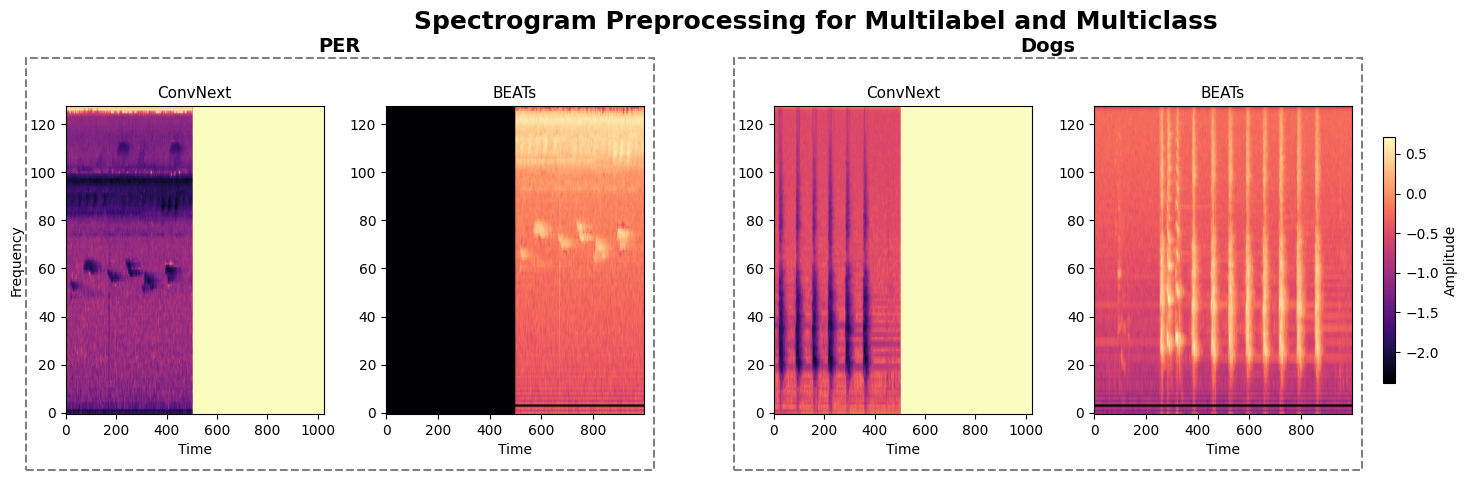

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec

# -- Prepare plot data --
plot_data = []
for key, spec in spectrograms.items():
    parts = key.split('_')
    model = parts[0]
    if "beans_dogs" in key:
        dataset = "Dogs"
    elif "PER" in key:
        dataset = "PER"
    else:
        dataset = parts[1].capitalize()
    idx = parts[-1]
    if int(idx) in [start_samples, start_samples_beans]:
        plot_data.append((dataset, model, spec))

datasets_order = ["PER", "Dogs"]
models_order = [m[0].__class__.__name__ for m in models]
n_datasets = len(datasets_order)
n_models = len(models_order)

# -- Setup GridSpec --
spacer_width = 0.02
total_columns = n_datasets * n_models + (n_datasets - 1)
width_ratios = []
for i in range(n_datasets):
    width_ratios.extend([1] * n_models)
    if i < n_datasets - 1:
        width_ratios.append(spacer_width)

fig = plt.figure(figsize=(4 * total_columns, 4))
gs = gridspec.GridSpec(1, total_columns, width_ratios=width_ratios, wspace=0.3)

# -- Build lookup --
plot_lookup = {(d, m): spec for d, m, spec in plot_data}
axes = []
last_im = None
col_idx = 0
group_positions = {}

# -- Plot spectrograms --
for dataset in datasets_order:
    axes_start = len(axes)
    for model in models_order:
        ax = fig.add_subplot(gs[0, col_idx])
        axes.append(ax)

        spec = plot_lookup.get((dataset, model))
        if spec is not None:
            img = spec.squeeze().cpu().numpy()
            if img.ndim == 3:
                img = img[0]
            if model == "BEATsModel" and img.shape[0] > img.shape[1]:
                img = img.T
            im = ax.imshow(img, aspect='auto', origin='lower', cmap='magma')
            last_im = im
        else:
            ax.axis('off')

        ax.set_xlabel('Time')
        if col_idx == 0:
            ax.set_ylabel('Frequency')
        else:
            ax.set_ylabel('')

        mname = "BEATs" if model == "BEATsModel" else "ConvNext"
        ax.set_title(mname, fontsize=11, pad=6)

        col_idx += 1
    axes_end = len(axes) - 1  # end index in axes[]
    group_positions[dataset] = (axes[axes_start], axes[axes_end])

    # Skip spacer column if not the last dataset
    if dataset != datasets_order[-1]:
        col_idx += 1

# -- Colorbar --
cbar = fig.colorbar(last_im, ax=axes, location='right', shrink=0.8, pad=0.02)
cbar.set_label('Amplitude')

# -- Overall title --
fig.suptitle("Spectrogram Preprocessing for Multilabel and Multiclass", fontsize=18, fontweight='bold', y=1.12)

# -- Group boxes --
for dataset, (start_ax, end_ax) in group_positions.items():
    pos_start = start_ax.get_position()
    pos_end = end_ax.get_position()

    x0 = pos_start.x0 - 0.02
    x1 = pos_end.x1 + 0.005
    y0 = pos_start.y0 - 0.14
    y1 = pos_start.y1 + 0.12

    rect = Rectangle((x0, y0), x1 - x0, y1 - y0,
                     transform=fig.transFigure,
                     fill=False, color='gray', linewidth=1.5, linestyle='--')
    fig.patches.append(rect)

    fig.text((x0 + x1) / 2, y1 + 0.005, dataset,
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.show()

## Plot Spectrograms
### Visualisation 1

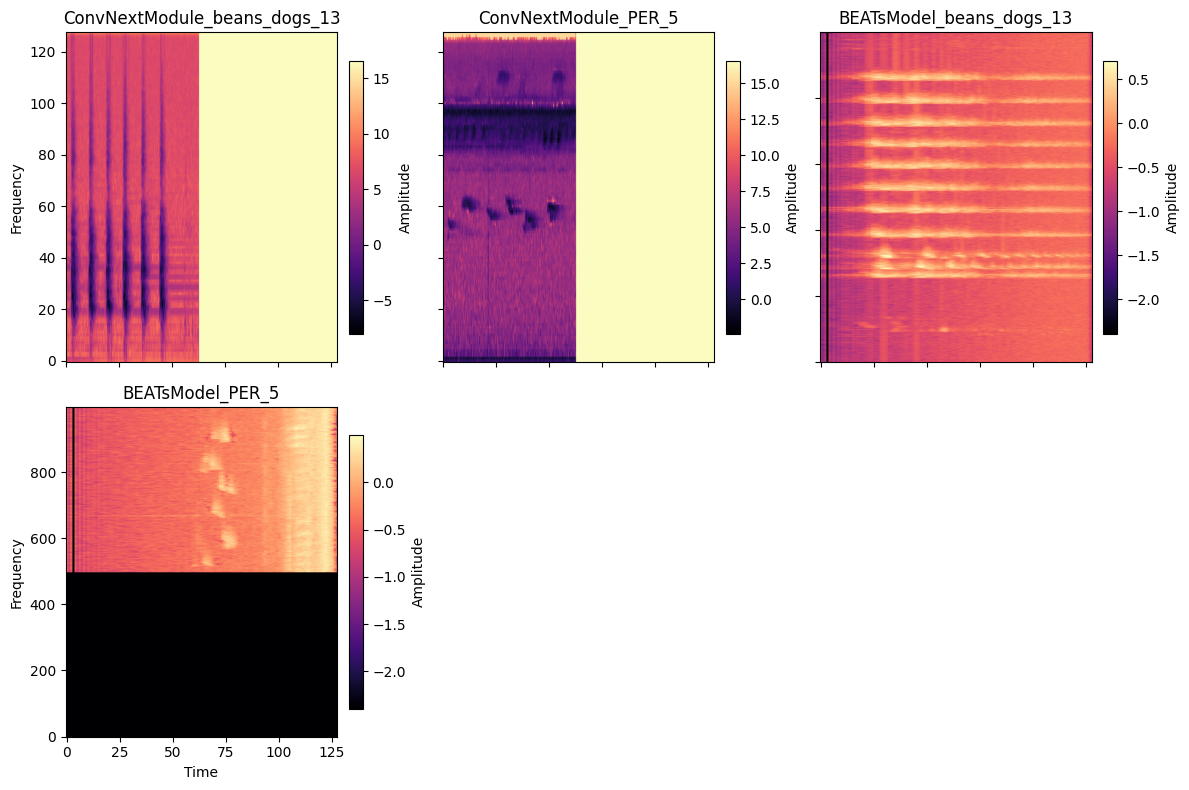

In [43]:
import matplotlib.pyplot as plt

n = len(spectrograms)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

for ax, (key, spec) in zip(axes.flat, spectrograms.items()):
    img = spec.squeeze().cpu().numpy()
    if img.ndim == 3:
        print("3D tensor detected, extracting first channel")
        img = img[0]
    #print(img.shape)
    im = ax.imshow(img, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(key)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.label_outer()
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude')

# Hide any unused subplots
for i in range(n, rows * cols):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()

### Visualisation 2

3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel


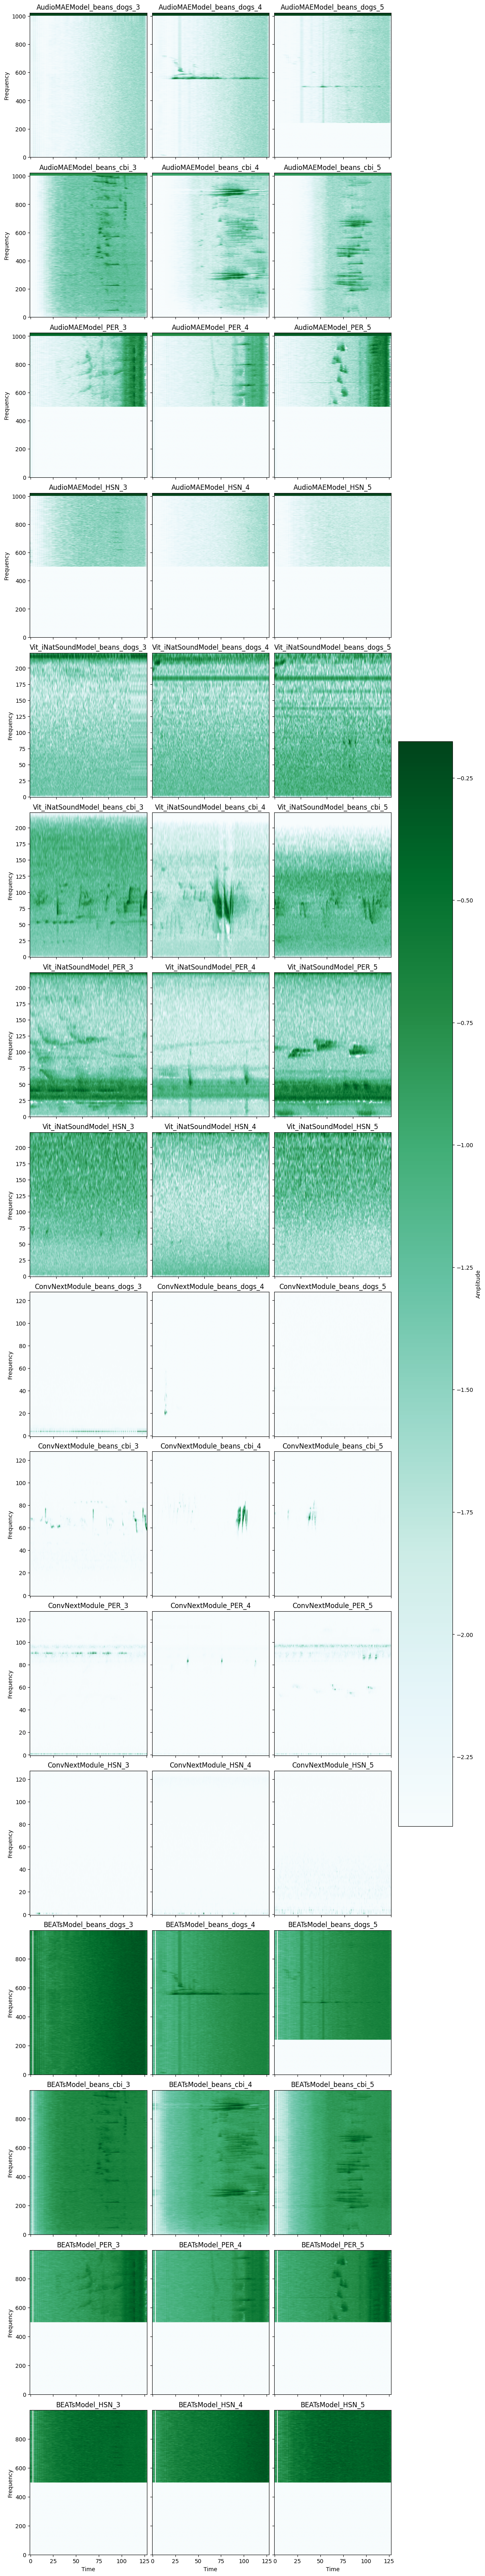

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a built-in colormap
cmap = "BuGn" #YlGnBu, BuGn, viridis

n = len(spectrograms)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows), constrained_layout=True)

# Ensure axes is always 2D
if rows == 1:
    axes = np.expand_dims(axes, axis=0)
if cols == 1:
    axes = np.expand_dims(axes, axis=1)

last_im = None

for ax, (key, spec) in zip(axes.flat, spectrograms.items()):
    img = spec.squeeze().cpu().numpy()
    if img.ndim == 3:
        print("3D tensor detected, extracting first channel")
        img = img[0]
    #print("Spectrogram shape:", img.shape)
    im = ax.imshow(img, aspect='auto', origin='lower', cmap=cmap)
    ax.set_title(key)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.label_outer()
    last_im = im

# One shared colorbar
cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), orientation='vertical', shrink=0.75, pad=0.02)
cbar.set_label('Amplitude')

# Hide unused subplots
for i in range(n, rows * cols):
    fig.delaxes(axes.flat[i])

plt.show()

### Visualisation 3

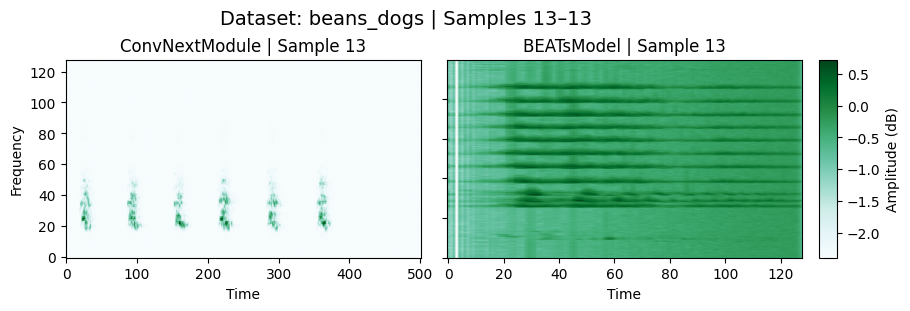

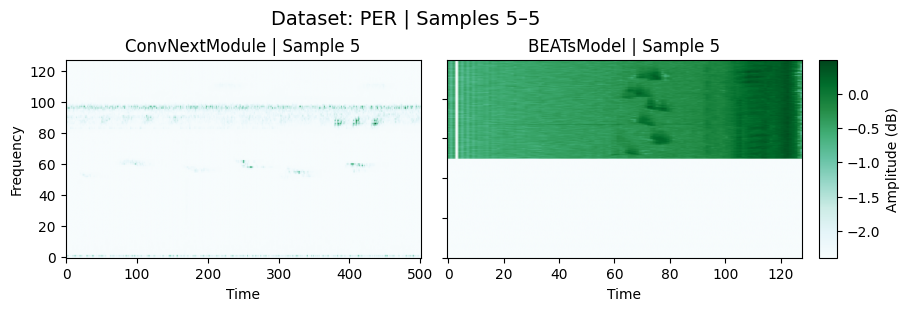

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Build full list of dataset names
dataset_names = [d for d, _ in beans_datasets] + birdset_datasets

# Robust key parser
def parse_key(key, dataset_names):
    """
    Given a key like 'ResNet_beans_dogs_3' and known dataset names,
    return (model, dataset, idx).
    """
    for dataset in dataset_names:
        search_str = f"_{dataset}_"
        if search_str in key:
            parts = key.split(search_str)
            if len(parts) != 2:
                raise ValueError(f"Cannot parse key: {key}")
            model = parts[0]
            idx = int(parts[1])
            return model, dataset, idx
    raise ValueError(f"Dataset name not found in key: {key}")

# Group spectrograms by dataset
dataset_groups = defaultdict(list)

for key, spec in spectrograms.items():
    model, dataset, idx = parse_key(key, dataset_names)
    dataset_groups[dataset].append((idx, model, key, spec))

# Process each dataset separately
for dataset in dataset_names:
    if dataset not in dataset_groups:
        print(f"No data for dataset '{dataset}'")
        continue

    # Sort entries by sample index
    entries = sorted(dataset_groups[dataset], key=lambda x: x[0])

    # Determine unique sample indices
    unique_indices = sorted(set(idx for idx, _, _, _ in entries))
    
    # You can adjust this as needed
    num_samples = len(models)

    for s in range(0, len(unique_indices), num_samples):
        block_indices = unique_indices[s:s+num_samples]

        # For each sample index, gather all models
        block_entries = []
        for idx in block_indices:
            for e in entries:
                if e[0] == idx:
                    block_entries.append(e)

        n = len(block_entries)
        cols = num_samples
        rows = (n + cols - 1) // cols

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(4 * cols, 3 * rows),
            constrained_layout=True
        )

        # Ensure axes is always 2D
        if rows == 1:
            axes = np.expand_dims(axes, axis=0)
        if cols == 1:
            axes = np.expand_dims(axes, axis=1)

        cmap = "BuGn"

        last_im = None

        for ax, (idx, model, key, spec) in zip(axes.flat, block_entries):
            img = spec.squeeze().cpu().numpy()
            if img.ndim == 3:
                #print("3D tensor detected, extracting first channel")
                img = img[0]
            #print(f"Plotting: {key} shape {img.shape}")
            im = ax.imshow(
                img,
                aspect='auto',
                origin='lower',
                cmap=cmap
                # No vmin/vmax here—auto scaling
            )
            ax.set_title(f"{model} | Sample {idx}")
            ax.set_xlabel('Time')
            ax.set_ylabel('Frequency')
            ax.label_outer()
            last_im = im

        # Shared colorbar in top-right inset
        cax = inset_axes(
            axes[0, -1],
            width="5%",
            height="100%",
            loc='upper left',
            bbox_to_anchor=(1.05, 0., 1, 1),
            bbox_transform=axes[0, -1].transAxes,
            borderpad=0,
        )
        cbar = fig.colorbar(last_im, cax=cax)
        cbar.set_label("Amplitude (dB)")

        # Hide any unused axes
        for i in range(n, rows * cols):
            fig.delaxes(axes.flat[i])

        fig.suptitle(f"Dataset: {dataset} | Samples {block_indices[0]}–{block_indices[-1]}", fontsize=14)

        plt.show()